In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

In [2]:
'''def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_BENDING\extreme_values.csv')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)
    df.to_csv('Bending_extreme_whole.csv', index=False)
    return df


df = read_data(type='BENDING', folder='Bending_extreme_values', length=14)
df.head()'''

"def read_data(type, folder, length):\n    df = pd.DataFrame()\n    parameters = pd.read_csv('Simulation_BENDING\\extreme_values.csv')\n    for i in range(length):\n        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')\n        mean_force = new_data['FKN'].mean()\n        max_force = new_data['FKN'].max()\n        new_data_df = pd.DataFrame()\n        new_data_df['mean_force'] = [mean_force]\n        new_data_df['max_force'] = [max_force]\n        for parameter in parameters.columns:\n            new_data_df[parameter] = parameters[parameter][i]\n        df = pd.concat([df, new_data_df])\n    df = df.drop(columns=['sample'])\n    df.reset_index(drop=True, inplace=True)\n    df.to_csv('Bending_extreme_whole.csv', index=False)\n    return df\n\n\ndf = read_data(type='BENDING', folder='Bending_extreme_values', length=14)\ndf.head()"

In [3]:
extremal_df = pd.read_csv('Bending_extreme_whole.csv')
training_df = pd.read_csv('Monte_Carlo_10000/training_data.csv')

In [4]:
X = training_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = training_df[['mean_force']].values
Y_EXT = extremal_df[['mean_force']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
generating_array = extremal_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
generating_array_scaled = scaler.transform(generating_array)
X_val = scaler.transform(X_val)

[1.00000000e-07 1.00100110e+00 2.00200210e+00 3.00300310e+00
 4.00400410e+00 5.00500510e+00 6.00600611e+00 7.00700711e+00
 8.00800811e+00 9.00900911e+00 1.00100101e+01 1.10110111e+01
 1.20120121e+01 1.30130131e+01 1.40140141e+01 1.50150151e+01
 1.60160161e+01 1.70170171e+01 1.80180181e+01 1.90190191e+01
 2.00200201e+01 2.10210211e+01 2.20220221e+01 2.30230231e+01
 2.40240241e+01 2.50250251e+01 2.60260261e+01 2.70270271e+01
 2.80280281e+01 2.90290291e+01 3.00300301e+01 3.10310311e+01
 3.20320321e+01 3.30330331e+01 3.40340341e+01 3.50350351e+01
 3.60360361e+01 3.70370371e+01 3.80380381e+01 3.90390391e+01
 4.00400401e+01 4.10410411e+01 4.20420421e+01 4.30430431e+01
 4.40440441e+01 4.50450451e+01 4.60460461e+01 4.70470471e+01
 4.80480481e+01 4.90490491e+01 5.00500501e+01 5.10510511e+01
 5.20520521e+01 5.30530531e+01 5.40540541e+01 5.50550551e+01
 5.60560562e+01 5.70570572e+01 5.80580582e+01 5.90590592e+01
 6.00600602e+01 6.10610612e+01 6.20620622e+01 6.30630632e+01
 6.40640642e+01 6.506506

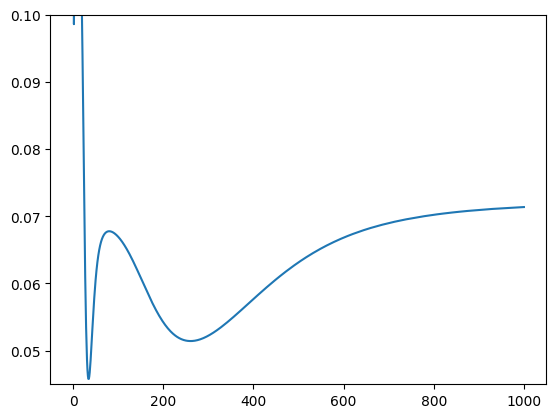

In [5]:
d0_values = np.linspace(0.0000001, 1000, 1000)
print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    results[d0_values[i]] = mse

plt.ylim(0.045, 0.1)
plt.plot(results.keys(), results.values())

In [6]:
RBF_model = RBF(d0=min(results, key=results.get))
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0000000
      Initializing linear solver - done. Time (sec):  0.0000000
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0000000
      Solving linear system (col. 0) - done. Time (sec):  0.0000000
   Training - done. Time (sec):  0.0059855


In [7]:
RBF_model = RBF(d0=min(results, key=results.get))
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0000000
      Initializing linear solver - done. Time (sec):  0.0000000
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0000000
      Solving linear system (col. 0) - done. Time (sec):  0.0009959
   Training - done. Time (sec):  0.0069785


In [8]:
predicted_values_RBF = RBF_model.predict_values(generating_array_scaled)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 14
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010014
   
   Prediction time/pt. (sec) :  0.0000715
   


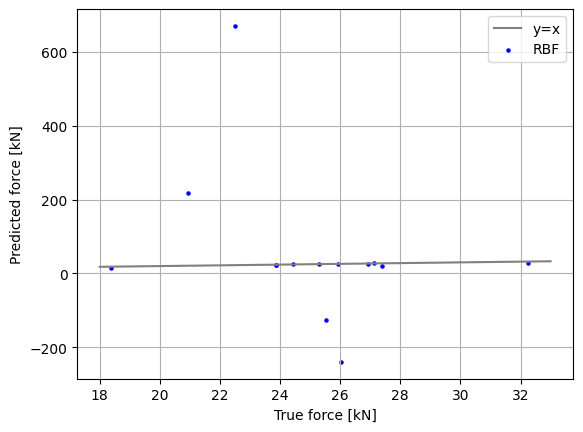

In [25]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,predicted_values_RBF , s=5, label='RBF', color='blue')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [10]:
gamma_values = np.logspace(-4, 2, num=50)
C_values = np.logspace(-1, 4, num=50)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

In [11]:
SVR_model = SVR(kernel='rbf', C=100, gamma= 0.1)
#SVR_model = SVR(kernel='rbf', epsilon=0.001, C=5.21)
SVR_model.fit(X_train,Y_train)

c:\Users\ben00\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

In [12]:
Y_predicted_SVR = SVR_model.predict(generating_array_scaled)

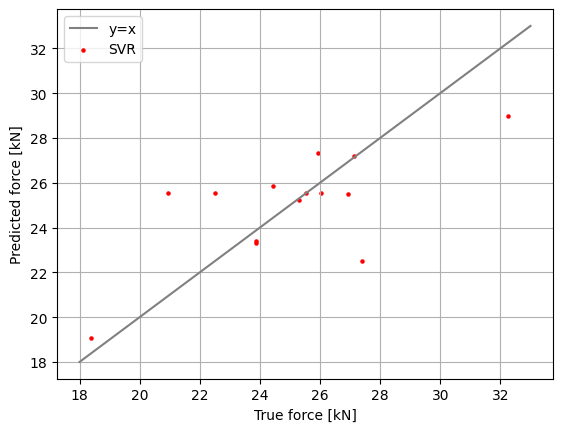

In [23]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [14]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.6018920


In [15]:
Y_predicted_KRG = KRG_model.predict_values(generating_array_scaled)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 14
   
   Predicting ...
   Predicting - done. Time (sec):  0.0129647
   
   Prediction time/pt. (sec) :  0.0009261
   


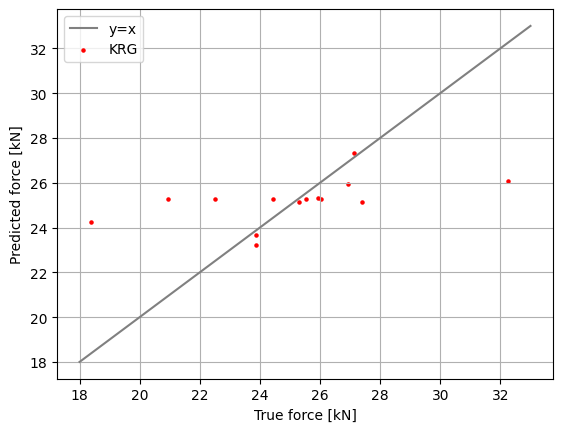

In [24]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,Y_predicted_KRG, s=5, label= 'KRG', color='red')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [17]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mse')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
3/3 [==============================] - 3s 511ms/step - loss: 630.5760 - val_loss: 620.1057
Epoch 2/1000
3/3 [==============================] - 0s 176ms/step - loss: 624.7323 - val_loss: 613.9974
Epoch 3/1000
3/3 [==============================] - 1s 286ms/step - loss: 618.3721 - val_loss: 607.1025
Epoch 4/1000
3/3 [==============================] - 0s 105ms/step - loss: 611.0995 - val_loss: 599.0698
Epoch 5/1000
3/3 [==============================] - 0s 78ms/step - loss: 602.5165 - val_loss: 589.5676
Epoch 6/1000
3/3 [==============================] - 0s 83ms/step - loss: 592.2863 - val_loss: 578.2070
Epoch 7/1000
3/3 [==============================] - 0s 77ms/step - loss: 580.0352 - val_loss: 564.5103
Epoch 8/1000
3/3 [==============================] - 0s 51ms/step - loss: 565.2360 - val_loss: 547.9825
Epoch 9/1000
3/3 [==============================] - 0s 44ms/step - loss: 547.7648 - val_loss: 528.2299
Epoch 10/1000
3/3 [==============================] - 0s 35ms/step - l

In [18]:
Y_predicted_ANN = model.predict(generating_array_scaled)

1/1 [==============================] - 0s 284ms/step


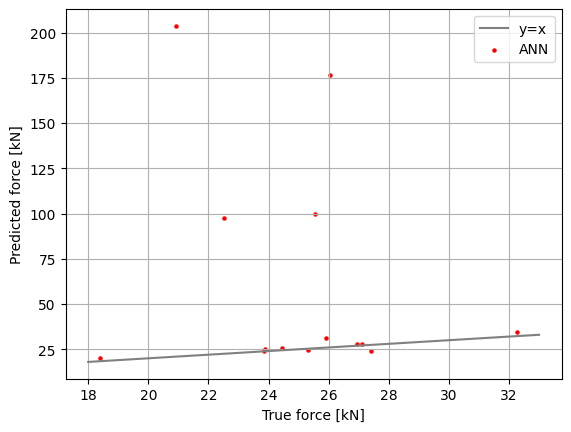

In [21]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,Y_predicted_ANN, s=5, label= 'ANN', color='red')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

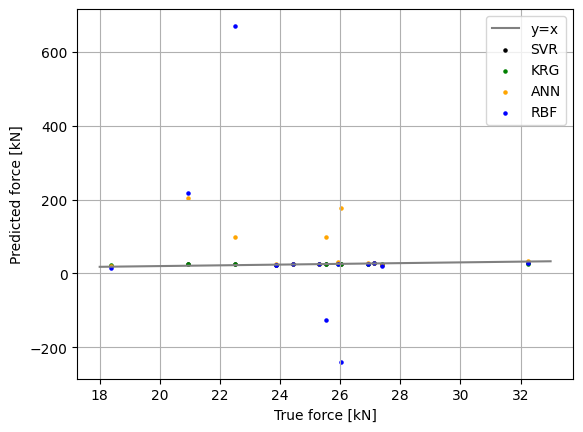

In [29]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')

plt.scatter(Y_EXT,Y_predicted_SVR, s=5, label= 'SVR', color='black')
plt.scatter(Y_EXT, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_EXT, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_EXT, predicted_values_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [30]:
mape_KRG = mean_absolute_percentage_error(Y_EXT, Y_predicted_KRG)
mape_RBF = mean_absolute_percentage_error(Y_EXT, predicted_values_RBF)
mape_SVR = mean_absolute_percentage_error(Y_EXT, Y_predicted_SVR)
mape_ANN = mean_absolute_percentage_error(Y_EXT, Y_predicted_ANN)
print("MAPE, for KRG:", round(mape_KRG, 4)*100, "%")
print("MAPE, for RBF:", round(mape_RBF, 4)*100, "%")
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")
print("MAPE, for ANN:", round(mape_ANN, 4)*100, "%")

MAPE, for KRG: 7.89 %
MAPE, for RBF: 393.14 %
MAPE, for SVR: 6.47 %
MAPE, for ANN: 153.51999999999998 %
